In [3]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import sys
import os
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (11,6),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [5]:
import torch
from sklearn.manifold import TSNE
import seaborn as sns

In [6]:
import pyarrow.dataset as ds
import pyarrow.feather as feather

In [7]:
from project.datasets import Dataset, CTRPDataModule
from project.models import FiLMNetwork, ConcatNetwork

In [7]:
def prepare(exp, subset=True):
    data_path = Path("../../film-gex-data/processed/")
    input_cols = joblib.load(data_path.joinpath("gene_cols.pkl"))
    
    if exp=='id':
        cpd_id = "master_cpd_id"
        cond_cols = np.array([cpd_id, 'cpd_conc_umol'])
    else:
        fp_cols = joblib.load(data_path.joinpath("fp_cols.pkl"))
        cond_cols = np.append(fp_cols, ['cpd_conc_umol'])
        
    if subset:
        dataset = ds.dataset(data_path.joinpath("train_sub.feather"), format='feather')
    else:
        dataset = ds.dataset(data_path.joinpath("train.feather"), format='feather')

    return dataset, input_cols, cond_cols

## Full Data Stats

In [12]:
data_path = Path("../../film-gex-data/processed/")
full_ds = ds.dataset(data_path.joinpath("train_sub.feather"), format='feather')
full_data = full_ds.to_table().to_pandas()

In [13]:
full_data.head()

,cpd_pv_errorbar,cpd_pred_pv,cpd_avg_pv,cpd_conc_umol,master_cpd_id,master_ccl_id,ccl_name,broad_cpd_id,cpd_smiles,stripped_cell_line_name,...,11000,6915,6253,7264,5467,2767,23038,57048,79716,fold
0,0.09101,0.6825,0.8263,2.100,63578,155366,NCIH841,BRD-A25004090,CCOc1ccccc1-n1c(=O)c2ccccc2nc1C(C)N1CCN(CC1)C(...,NCIH841,...,4.034744,1.608809,3.655352,5.481234,3.731183,4.284662,4.015248,6.926948,4.053980,4
1,0.00000,1.0000,1.1510,0.036,411714,965,REH,BRD-A31107743,CC1CCC\C=C/C2CC(O)CC2C(O)\C=C/C(=O)O1,REH,...,5.499208,0.411426,3.005400,6.379205,3.674687,4.575917,3.358959,4.916477,4.253989,1
2,0.07875,0.8893,0.9546,0.160,1788,155505,NCIH2228,BRD-K46556387,CN(C)CCNC(=O)c1cc2CSc3cc(Cl)ccc3-c2s1,NCIH2228,...,3.310340,0.275007,1.137504,5.956986,4.255501,5.995485,3.611172,3.507160,3.995485,0
3,0.00000,1.0000,1.0350,2.100,660253,683,MKN45,BRD-M94343540,OC(=O)CC[C@H]1CC[C@@](CC1)(c1cc(F)ccc1F)S(=O)(...,MKN45,...,2.438293,0.014355,2.807355,7.823622,3.694880,4.919340,4.390943,4.173927,4.253989,4
4,0.00000,1.0000,1.0820,0.130,18311,263,G361,BRD-A18763547,OC(CN1CCNCC1)Cn1c2ccc(Br)cc2c2cc(Br)ccc12,G361,...,8.369597,0.831877,1.411426,5.897724,3.565597,4.847997,3.173127,3.454176,3.614710,0


In [ ]:
for c in full_data.columns: print(c, full_data[c].nunique())
print(full_data.shape)
del full_data

In [8]:
ds_path = Path("../../film-gex-data/drug_screens/")
ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.data.per_cpd_post_qc.txt") ,sep='\t', index_col=0)

/srv/home/wconnell/anaconda3/envs/lightning/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
ctrp.head()

,cpd_pv_errorbar,cpd_pred_pv,cpd_avg_pv,cpd_conc_umol,master_cpd_id
experiment_id,,,,,
1,0.000058,1.0,0.9303,0.00030,1788
1,0.000058,1.0,0.8337,0.00061,1788
1,0.000058,1.0,1.0460,0.00120,1788
1,0.000058,1.0,1.0910,0.00240,1788
1,0.000058,1.0,1.0190,0.00490,1788


In [11]:
ctrp.reset_index().groupby(['experiment_id', 'master_cpd_id']).size()

experiment_id  master_cpd_id
1              1788             16
               3588             16
               12877            16
               19153            11
               23256            16
                                ..
907            688975           16
               689136           16
               689506           13
               705300           16
               710154           16
Length: 395263, dtype: int64

<AxesSubplot:xlabel='cpd_conc_umol'>

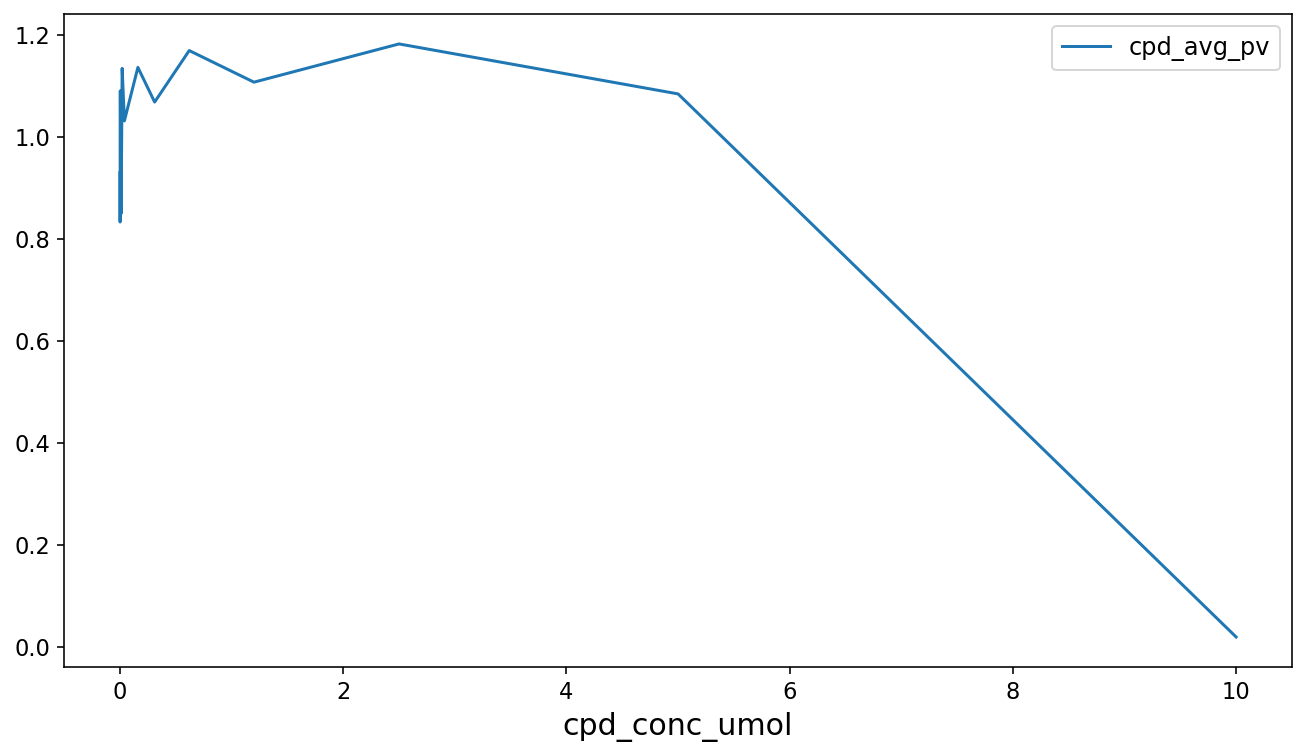

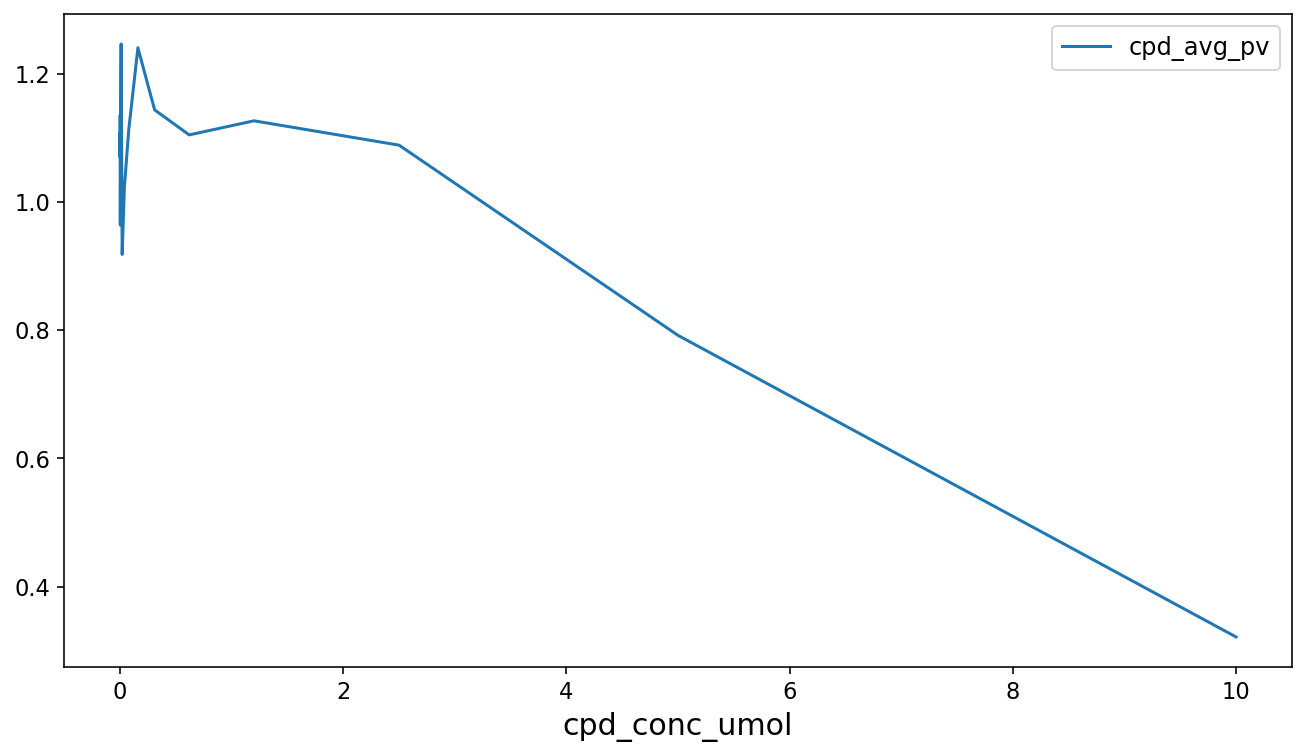

In [31]:
ctrp[ctrp['master_cpd_id']==1788].loc[1].plot('cpd_conc_umol', 'cpd_avg_pv')
ctrp[ctrp['master_cpd_id']==1788].loc[10].plot('cpd_conc_umol', 'cpd_avg_pv')

<AxesSubplot:xlabel='cpd_conc_umol'>

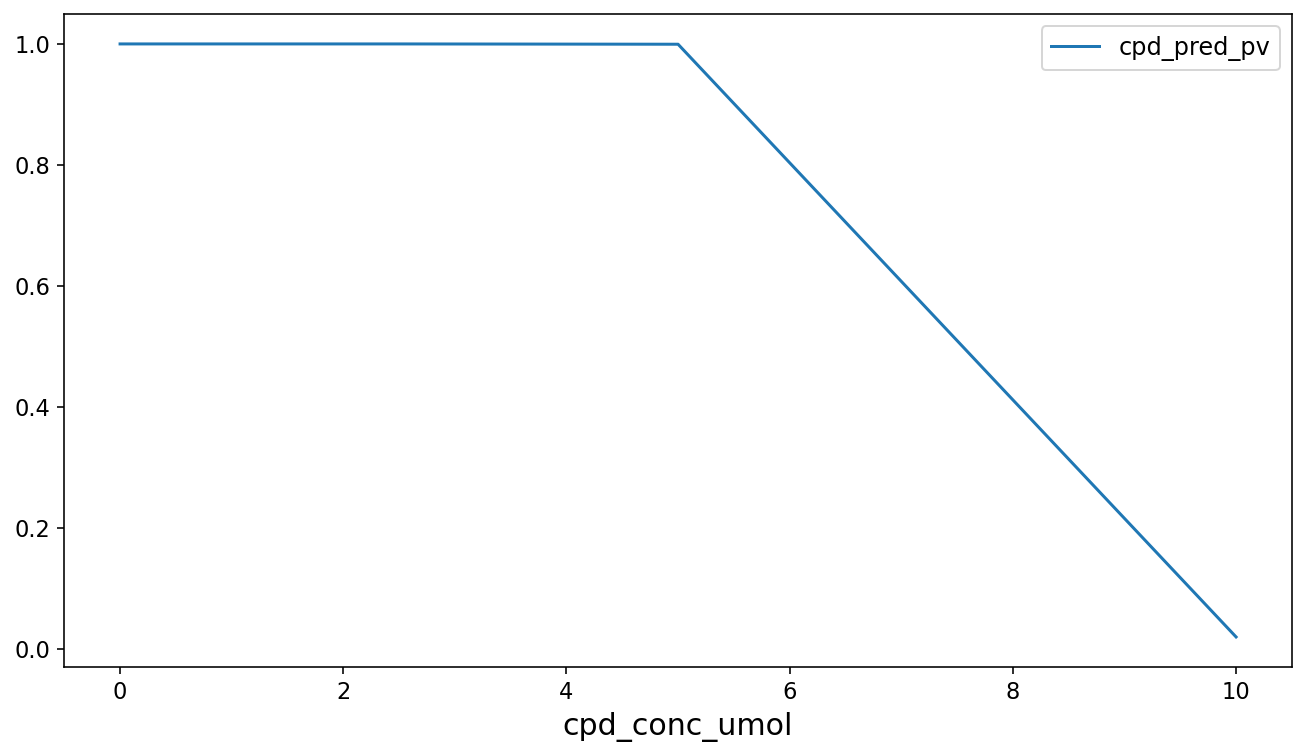

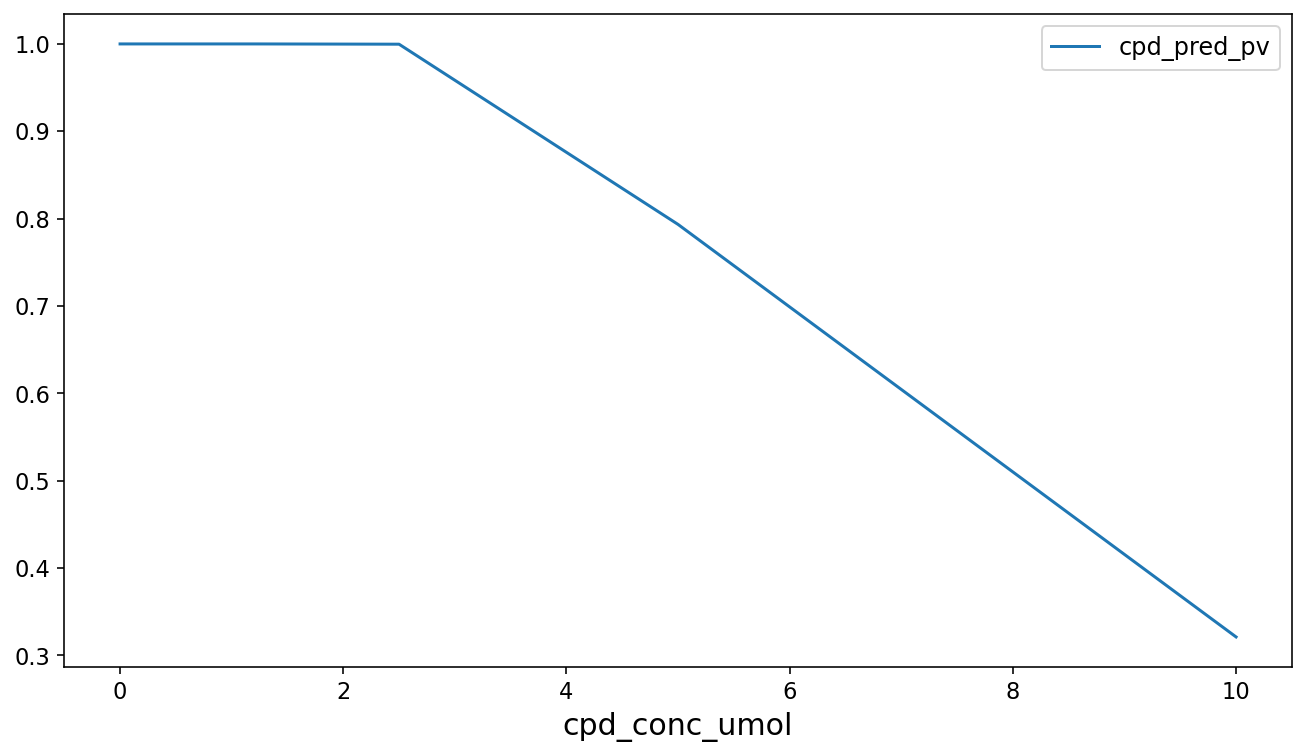

In [32]:
ctrp[ctrp['master_cpd_id']==1788].loc[1].plot('cpd_conc_umol', 'cpd_pred_pv')
ctrp[ctrp['master_cpd_id']==1788].loc[10].plot('cpd_conc_umol', 'cpd_pred_pv')

In [17]:
test = Path("test")

## Read Data

In [37]:
exp = 'film'
fold = 0

In [38]:
dataset, input_cols, cond_cols = prepare(exp, subset=True)
cols = list(np.concatenate((input_cols, cond_cols, ['cpd_avg_pv']))) 

In [39]:
train = dataset.to_table(columns=cols, filter=ds.field('fold') != fold).to_pandas()
val = dataset.to_table(columns=cols, filter=ds.field('fold') == fold).to_pandas()

In [40]:
dm = CTRPDataModule(train,
                    val,
                    input_cols,
                    cond_cols,
                    target='cpd_avg_pv',
                    batch_size=32768)

In [41]:
dm.setup(stage='fit')

Completed scaling in 0:02:11.830630
Completed dataset creation in 0:00:11.623557


(<project.datasets.Dataset at 0x7f7470c59340>,
 <project.datasets.Dataset at 0x7f7470bc9d60>)

##### MetaData

In [42]:
meta_val_cpd = dataset.to_table(columns=['master_cpd_id', 'cpd_conc_umol', 'cpd_avg_pv'], filter=ds.field('fold') == fold).to_pandas()
meta_val_line = dataset.to_table(columns=['stripped_cell_line_name'], filter=ds.field('fold') == fold).to_pandas()

In [43]:
_, cpd_idx = np.unique(meta_val_cpd[['master_cpd_id', 'cpd_conc_umol']], return_index=True, axis=0)
meta_val_cpd = meta_val_cpd.iloc[cpd_idx, :].set_index('master_cpd_id')
meta_val_cpd['log_cpd_conc'] = np.log1p(meta_val_cpd['cpd_conc_umol'])

_, line_idx = np.unique(meta_val_line, return_index=True)
meta_val_line = meta_val_line.iloc[line_idx, :].set_index('stripped_cell_line_name')

In [44]:
print(meta_val_cpd.shape)
print(meta_val_line.shape)

(8852, 3)
(166, 0)


##### Compound target data

In [45]:
ds_path = Path("../../film-gex-data/drug_screens/")
cp_ctrp = pd.read_csv(ds_path.joinpath("CTRP/v20.meta.per_compound.txt"), sep="\t", index_col=0)

In [46]:
meta_val_cpd = meta_val_cpd.join(cp_ctrp)

In [101]:
from scipy.optimize import curve_fit
from scipy.stats import logistic

In [138]:
def ll4(x,b,c,d,e):
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

Text(0.5, 1.0, 'Erlotinib')

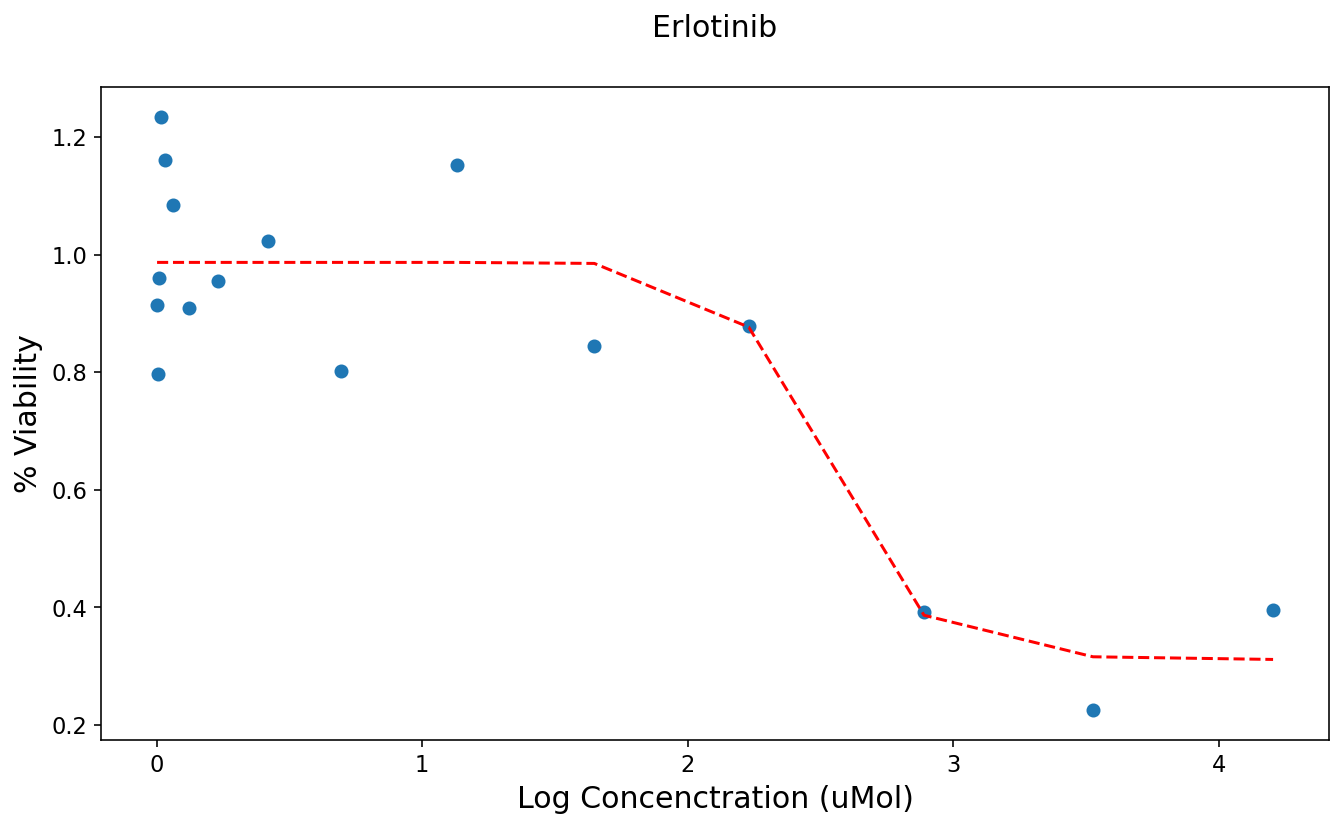

In [240]:
x = meta_val_cpd[meta_val_cpd['cpd_name']=='erlotinib']['log_cpd_conc'].values
y = meta_val_cpd[meta_val_cpd['cpd_name']=='erlotinib']['cpd_avg_pv'].values
popt, pcov = curve_fit(ll4, x, y)
plt.plot(x, y, ".", ms=12)
plt.plot(x, ll4(x, *popt), 'r--')

plt.xlabel('Log Concenctration (uMol)')
plt.ylabel('% Viability')
plt.title('Erlotinib')

Text(0.5, 1.0, 'Sirolimus')

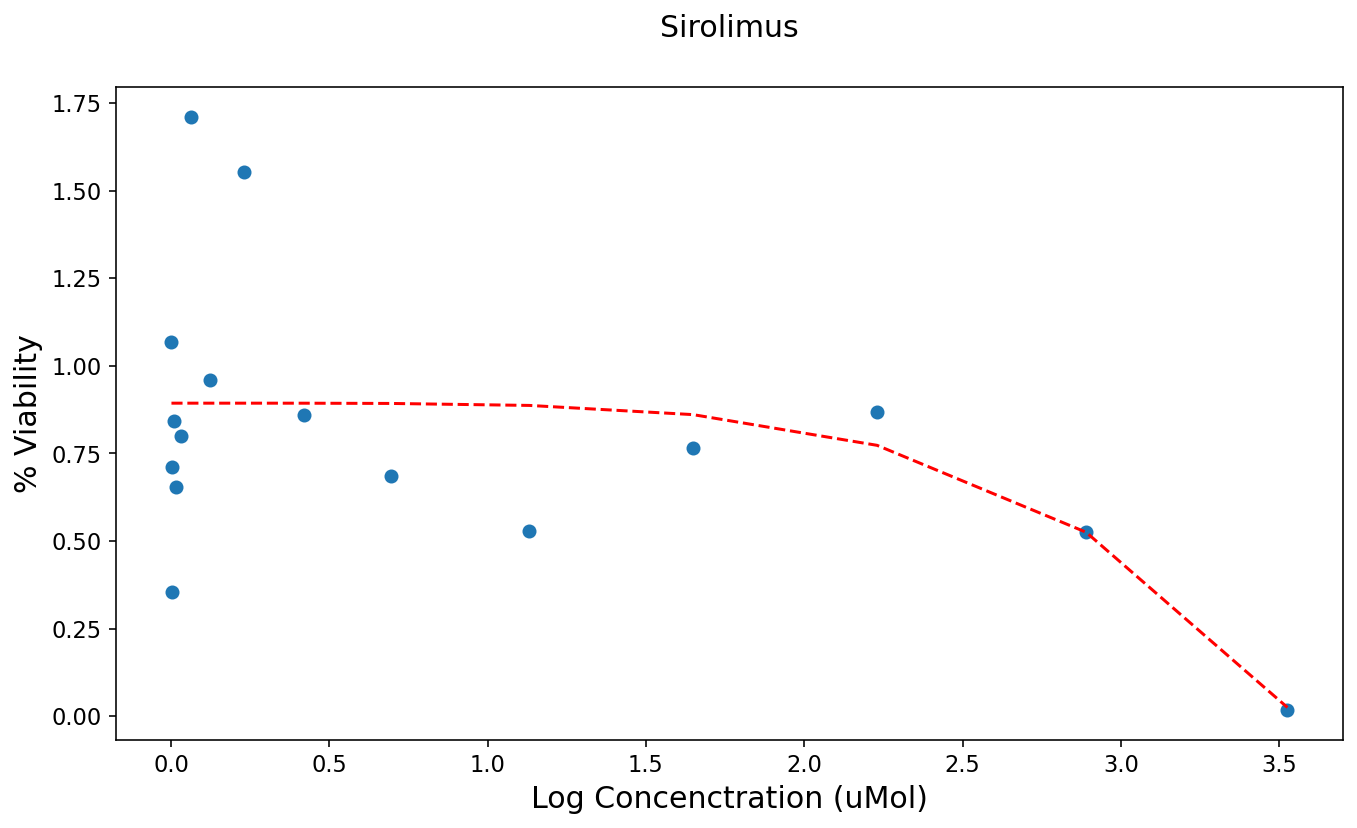

In [241]:
x = meta_val_cpd[meta_val_cpd['cpd_name']=='sirolimus']['log_cpd_conc'].values
y = meta_val_cpd[meta_val_cpd['cpd_name']=='sirolimus']['cpd_avg_pv'].values
popt, pcov = curve_fit(ll4, x, y)
plt.plot(x, y, ".", ms=12)
plt.plot(x, ll4(x, *popt), 'r--')
plt.xlabel('Log Concenctration (uMol)')
plt.ylabel('% Viability')
plt.title('Sirolimus')

### Load Model

In [47]:
film_model = FiLMNetwork.load_from_checkpoint("../project/lightning_logs/gpu3_film_fold_0/checkpoints/epoch=22.ckpt")
concat_model = ConcatNetwork.load_from_checkpoint("../project/lightning_logs/gpu7_concat_fold_0/checkpoints/epoch=18.ckpt")
film_model.freeze()
concat_model.freeze()

In [48]:
# load proceessed data (stdscaled)
inputs, conds, y = dm.val_dataset[:]

In [49]:
conds_uq = conds[cpd_idx]
inputs_uq = inputs[line_idx]

In [50]:
# film emb
film_inputs_emb = film_model.inputs_emb(inputs_uq)
film_conds_emb = film_model.conds_emb(conds_uq)

In [51]:
# concat emb
concat_inputs_emb = concat_model.inputs_emb(inputs_uq)
concat_conds_emb = concat_model.conds_emb(conds_uq)

## Prediction Evaluation

In [65]:
inputs_emb, conds_a_emb, conds_b_emb, y_hat = film_model(inputs, conds, conds)

In [84]:
preds = pd.DataFrame({'y':y,
                      'y_hat':y_hat.squeeze().numpy()})

In [86]:
preds.describe()

,y,y_hat
count,116249.000000,116249.000000
mean,0.856550,0.851482
std,0.299003,0.257908
min,0.002906,-0.263816
25%,0.807100,0.813273
50%,0.967300,0.975770
75%,1.032000,1.005932
max,2.881000,1.278045


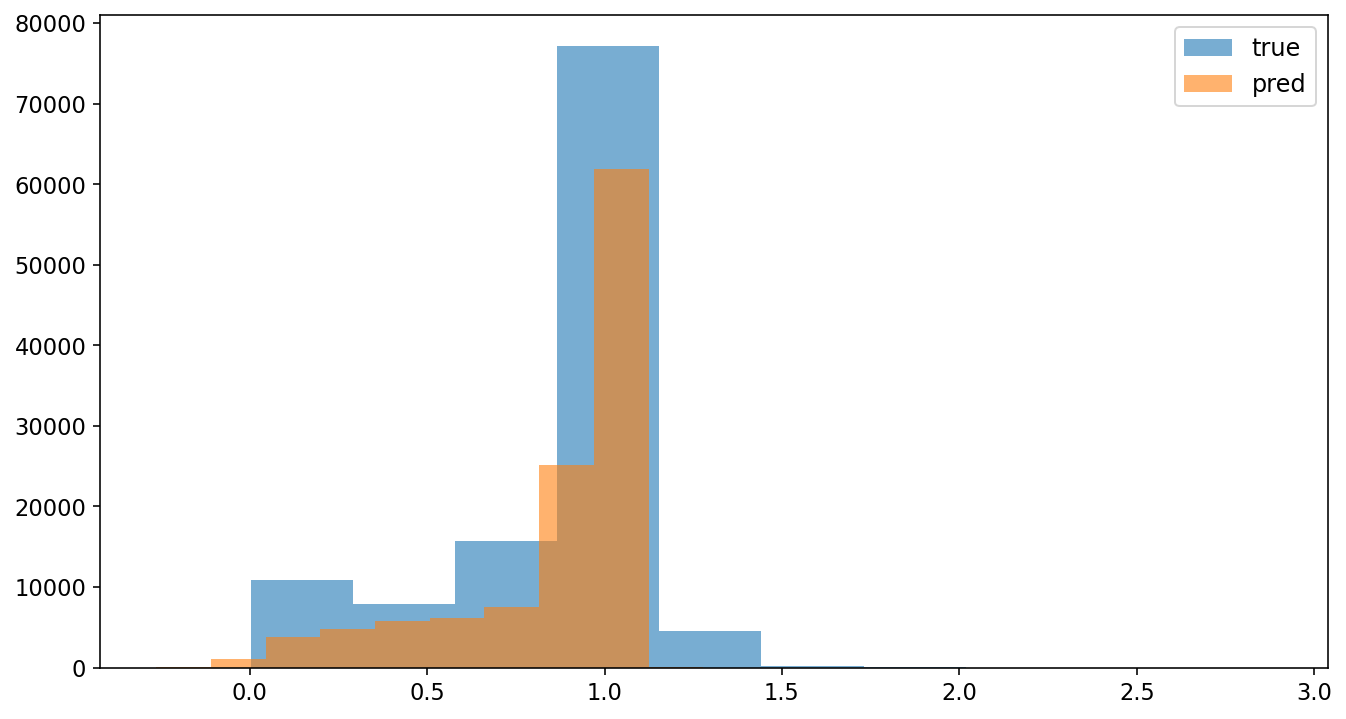

In [93]:
plt.hist(preds['y'], alpha=0.6, label='true')
plt.hist(preds['y_hat'], alpha=0.6, label='pred')
plt.legend()

## FiLM Parameter Analysis

In [247]:
film1_gamma, film1_beta = film_model.film_1(film_conds_emb)
film2_gamma, film2_beta = film_model.film_2(film_conds_emb)

In [248]:
from sklearn.manifold import TSNE

### Film 1

In [249]:
# First Film Layer
tsne = TSNE()
film1_tsne = tsne.fit_transform(torch.cat([film1_gamma, film1_beta]).numpy())

film1_params = pd.concat([meta_val_cpd.copy(), meta_val_cpd.copy()])
film1_params['param'] = np.concatenate((np.repeat('gamma', len(film1_gamma)), np.repeat('beta', len(film1_beta))))
film1_params['TSNE_0'] = film1_tsne[:,0]
film1_params['TSNE_1'] = film1_tsne[:,1]

In [250]:
target = 'MTOR'
col = 'gene_symbol_of_protein_target'
film1_params['highlight'] = np.where(film1_params[col]==target, target, 'NA')

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

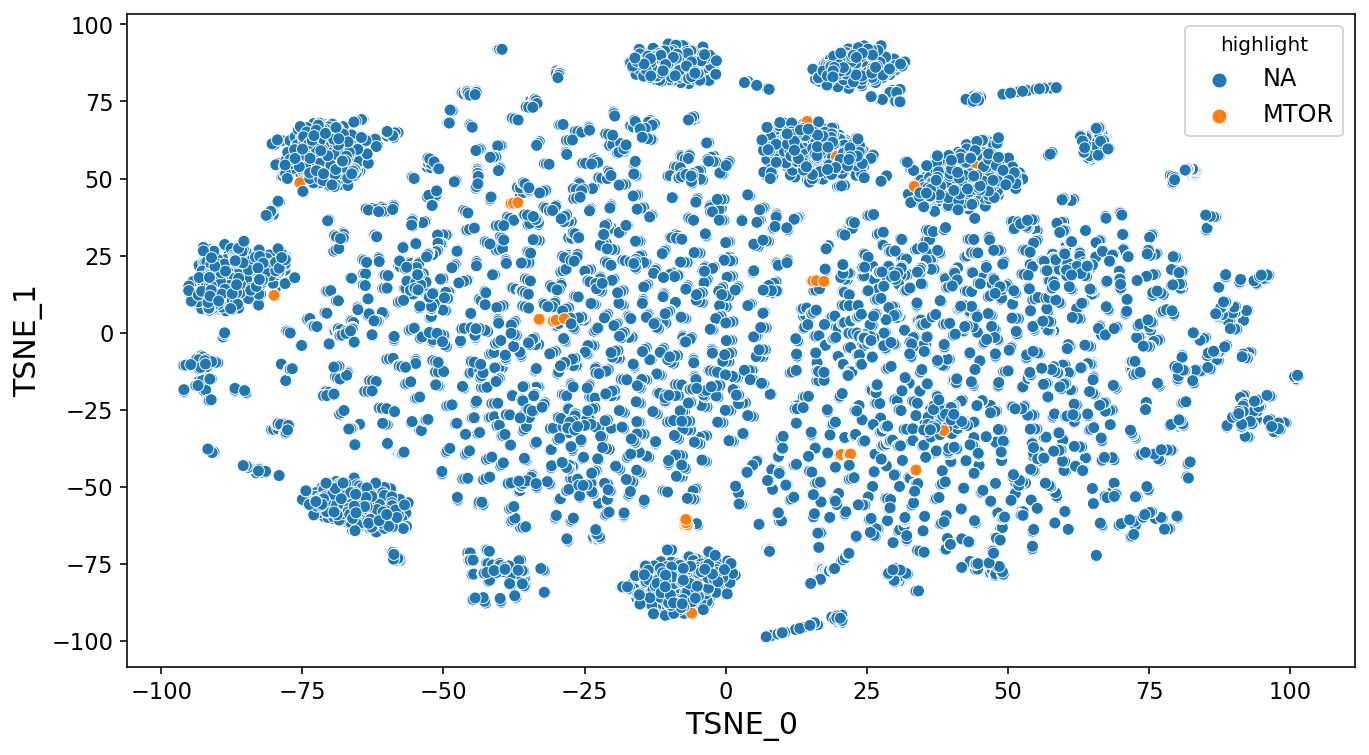

In [251]:
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='highlight', data=film1_params)

<AxesSubplot:xlabel='TSNE_0', ylabel='TSNE_1'>

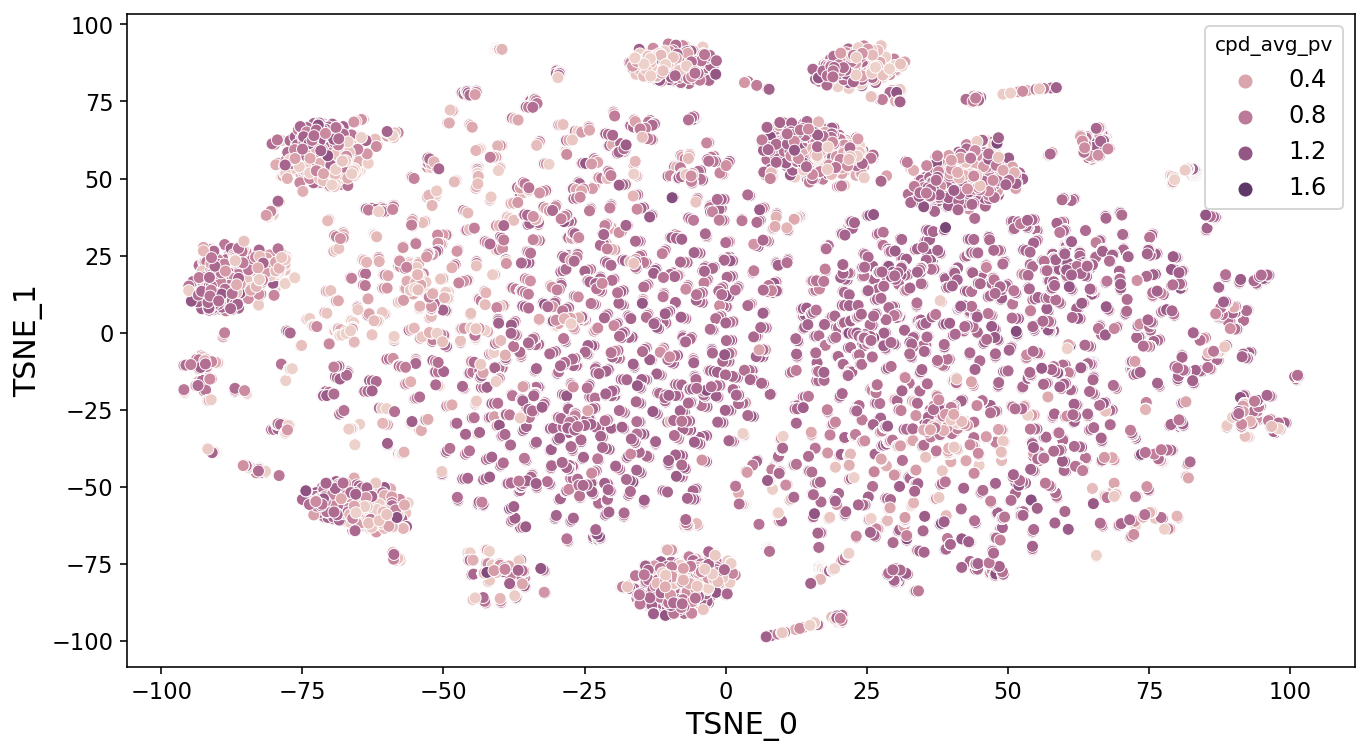

In [252]:
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='cpd_avg_pv', data=film1_params)

Text(0.5, 1.0, 'First FiLM Parameters')

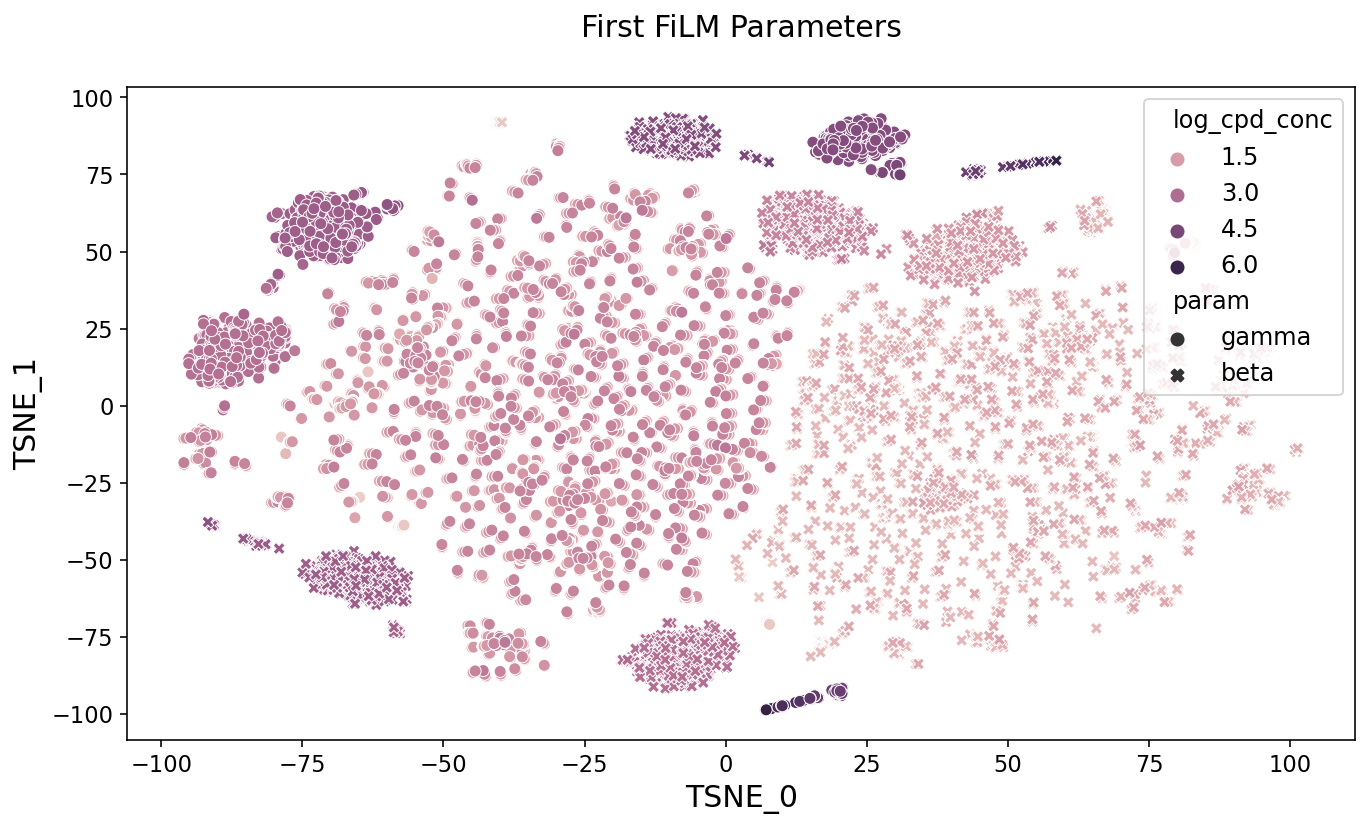

In [253]:
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='log_cpd_conc', style='param', data=film1_params)
ax.tick_params(labelsize=10)
plt.title('First FiLM Parameters')

### Film 2

In [ ]:
# Second Film Layer
tsne = TSNE()
film2_tsne = tsne.fit_transform(torch.cat([film2_gamma, film2_beta]).numpy())

film2_params = pd.concat([meta_val_cpd.copy(), meta_val_cpd.copy()])
film2_params['param'] = np.concatenate((np.repeat('gamma', len(film2_gamma)), np.repeat('beta', len(film2_beta))))
film2_params['TSNE_0'] = film2_tsne[:,0]
film2_params['TSNE_1'] = film2_tsne[:,1]
film2_params['log_cpd_conc'] = np.log1p(film2_params['cpd_conc_umol'])

Text(0.5, 1.0, 'Second FiLM Parameters')

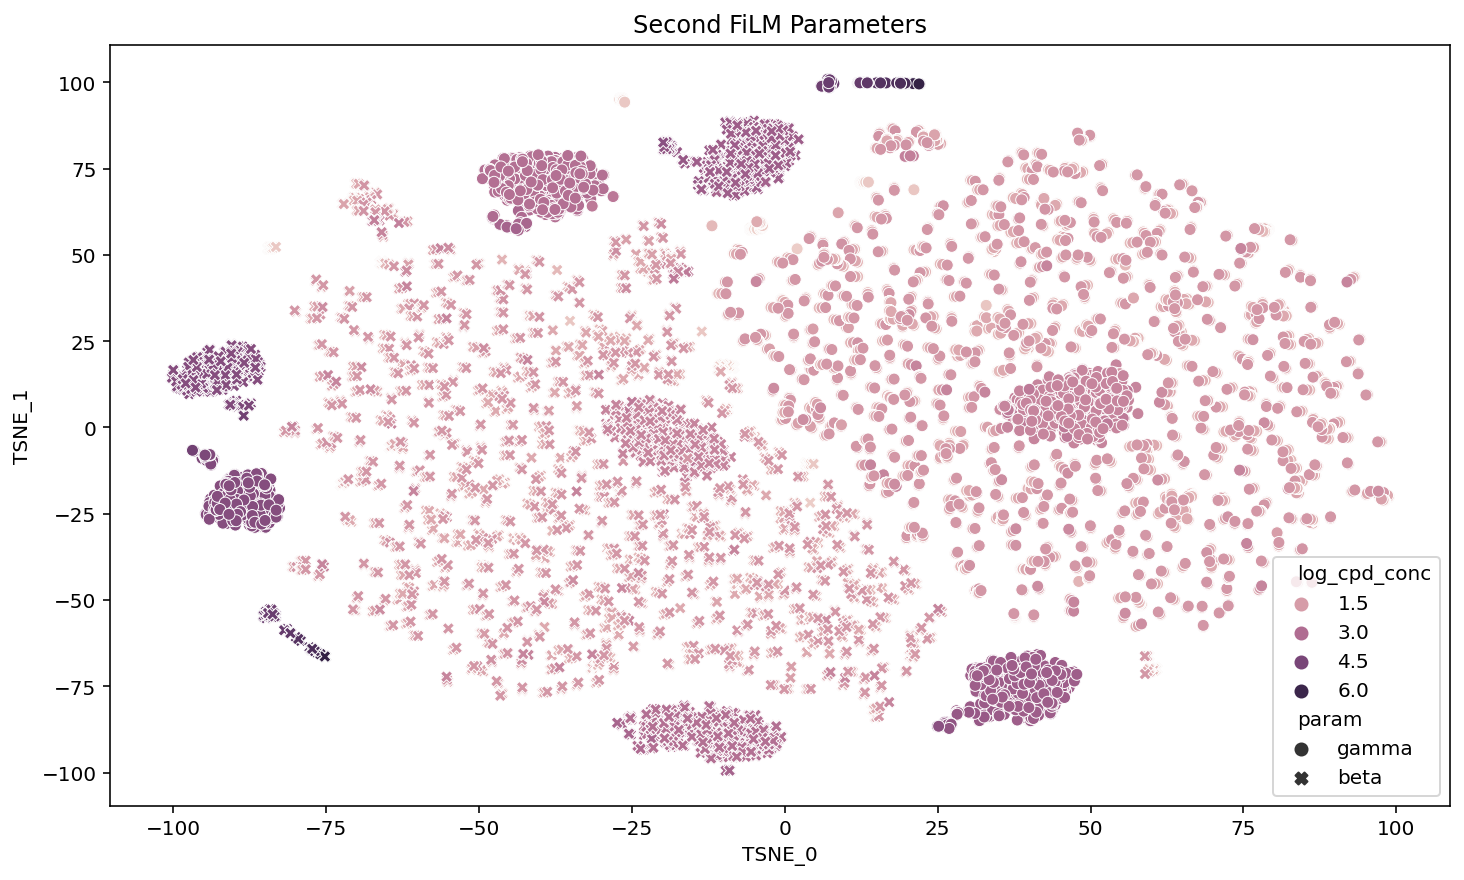

In [356]:
sns.scatterplot(x='TSNE_0', y='TSNE_1', hue='log_cpd_conc', style='param', data=film2_params)
plt.title('Second FiLM Parameters')

### Concat Embedding Analysis

In [223]:
tnse = TSNE()
conds_tsne = tnse.fit_transform(concat_conds_emb.numpy())

tnse = TSNE()
inputs_tsne = tnse.fit_transform(concat_inputs_emb.numpy())

<AxesSubplot:>

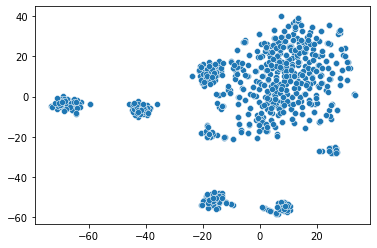

In [224]:
sns.scatterplot(x=conds_tsne[:,0], y=conds_tsne[:,1])

### Logs

In [165]:
from tensorboard.backend.event_processing import event_accumulator

In [166]:
def ea_to_df(path, metric):
    for i in os.listdir(path):
        if os.path.isfile(os.path.join(path,i)) and 'events.out.tfevents' in i:
            ea = event_accumulator.EventAccumulator(os.path.join(path, i))
            ea.Reload()
            _, step, value = zip(*ea.Scalars(metric))
            name, model, _, fold = os.path.split(path)[1].split("_")
            df = pd.DataFrame({'model': np.repeat(model, len(step)),
                               'fold': np.repeat(fold, len(step)),
                               'epoch': np.arange(1, len(step)+1),
                               'step': step,
                               metric: value})
    return df

In [169]:
path = "../project/lightning_logs/"
metric = 'train_loss'
train_loss = pd.concat([ea_to_df(os.path.join(path, p), metric) for p in os.listdir(path)])
train_loss = train_loss[train_loss['model']!='id']

In [264]:
path = "../project/lightning_logs/"
metric = 'epoch_val_loss'
val_loss = pd.concat([ea_to_df(os.path.join(path, p), metric) for p in os.listdir(path)])
val_loss = val_loss[val_loss['model']!='id']

val_loss_avg = val_loss.groupby(['model', 'epoch']).mean().reset_index()
val_loss_min_avg = val_loss_avg.groupby(['model']).min()

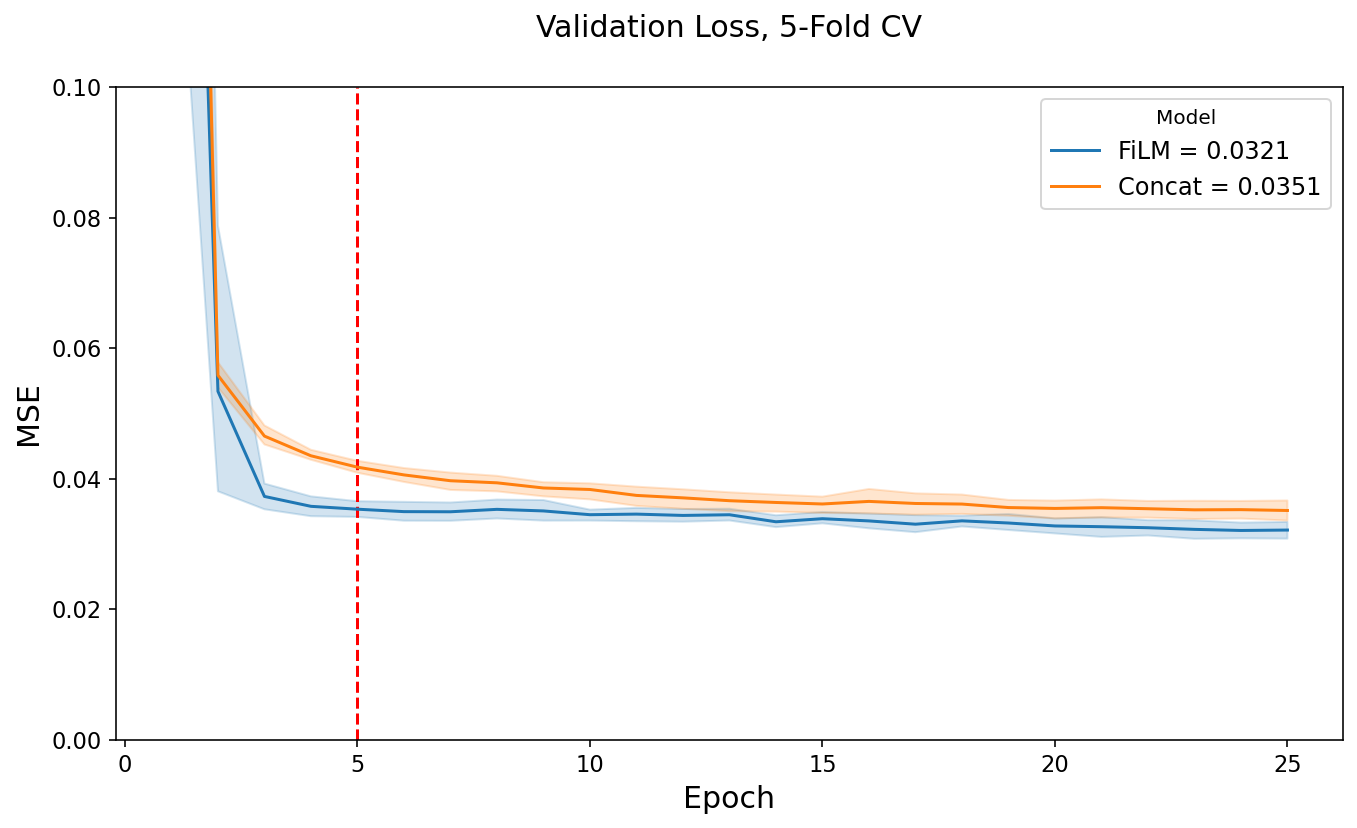

In [265]:
g = sns.lineplot(x='epoch', y='epoch_val_loss', hue='model', data=val_loss, legend=False)
# replace labels
labels = ['FiLM = {0:.4f}'.format(val_loss_min_avg.loc['film', 'epoch_val_loss']), 
          'Concat = {0:.4f}'.format(val_loss_min_avg.loc['concat', 'epoch_val_loss'])]
plt.legend(title='Model', loc='upper right', labels=labels)
plt.ylim(0, 0.1)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation Loss, 5-Fold CV')
plt.vlines(5, ymin=0, ymax=0.1, colors='r', linestyles='--')
plt.show(g)

In [274]:
path = "../project/lightning_logs/"
metric = 'val_r2'
r2 = pd.concat([ea_to_df(os.path.join(path, p), metric) for p in os.listdir(path)])
r2 = r2[r2['model']!='id']

r2_avg = r2.groupby(['model', 'epoch']).mean().reset_index()
r2_max_avg = r2_avg.groupby(['model']).max()

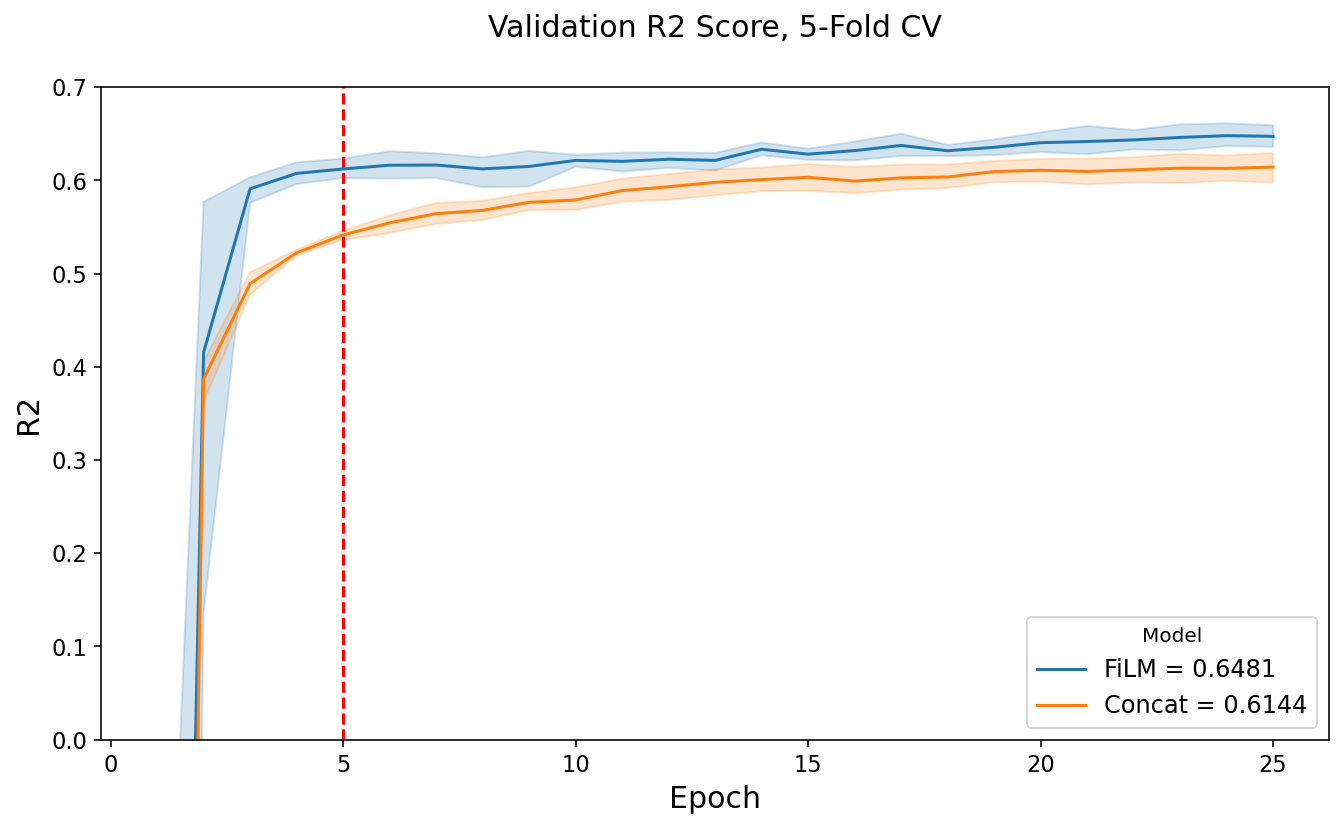

In [275]:
g = sns.lineplot(x='epoch', y=metric, hue='model', data=r2, legend=False)

# replace labels
labels = ['FiLM = {0:.4f}'.format(r2_max_avg.loc['film', 'val_r2']), 
          'Concat = {0:.4f}'.format(r2_max_avg.loc['concat', 'val_r2'])]

plt.legend(title='Model', loc='lower right', labels=labels)
plt.ylim(0, 0.7)
plt.ylabel("R2")
plt.xlabel("Epoch")
plt.title("Validation R2 Score, 5-Fold CV")
plt.vlines(5, ymin=0., ymax=0.7, colors='r', linestyles='--')
plt.show(g)